## Домашнее задание 8
1. Обучить генератор создавать точки, которые будут лежать на графике функции 
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

## Решение

Импортируем необходимые библиотеки.

In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from sklearn.model_selection import train_test_split
import matplotlib.patches as mpatches

Проверим систему на наличие видеокарты, которую можно будет использовать в процессе обучения.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Сгенерим данные, которые будут использоваться для обучения нашей модели.

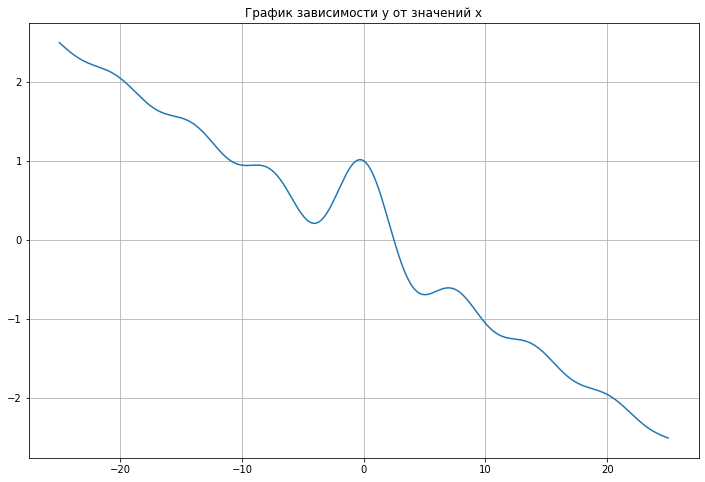

In [3]:
x = np.linspace(-25, 25, 50000)

# Определим значение функции в точке 0 как нулевое
y = np.array([np.sin(el) / el - el / 10 for el in x])

plt.figure(figsize=(12, 8))
plt.title('График зависимости у от значений x')
plt.grid()
plt.plot(x, y);

Зададим гиперпараметры, которые будут использоваться в дальнейшем.

In [4]:
n_epochs = 75  # количество эпох
lr = 0.0001  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

latent_dim = 200  # Размерность случайного вектора, который подается на вход генератору

sample_interval = 500  # количество итераций для отображения процесса обучения

batch_size = 128

Создадим класс датасета и затем определим даталоадеры для удобства процесса обучения.

In [5]:
class FunctionDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, train=True):
          self.data = x
          self.values = y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.values[index]


dataset = FunctionDataset(x, y)

dataloader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=2)

Определяем генератор и дискриминатор.

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]  
            
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))

            layers.append(self.activations[activation])
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256, activation='lrelu'),
            *block(256, 512, activation='lrelu'),
            *block(512, 1024),
            nn.Linear(1024, 2),
        )
        self.double()

    def forward(self, z):
        pred = self.model(z)
        return pred

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()],
            ['sigmoid', nn.Sigmoid()],
        ])

        def block(in_feat, out_feat, normalize=False, activation='lrelu'):
            layers = [nn.Linear(in_feat, out_feat)]
            
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
                
            layers.append(self.activations[activation]) 
            
            return layers

        self.model = nn.Sequential(
            *block(2, 1024),
            *block(1024, 512),
            *block(512, 256),
            *block(256, 1, activation='sigmoid'),
        )
        
        self.double()
  

    def forward(self, x):
        validity = self.model(x)
        return validity

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

[Epoch 74/75] [Batch 66/391]|[D loss: 0.694675171757245] [G loss: 0.6656771702782618]


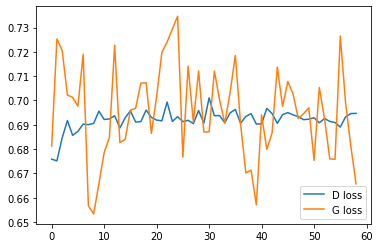

In [9]:
d_loss_history = []
g_loss_history = []

for epoch in range(n_epochs):
    for i, (x_val, y_val) in enumerate(dataloader):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.DoubleTensor(len(x_val), 1).fill_(1.0).to(device)
        fake = torch.DoubleTensor(len(x_val), 1).fill_(0.0).to(device)

        real_xy_values = torch.stack((x_val.to(device), y_val.to(device)), -1)

        # Генерация шума
        z = torch.DoubleTensor(np.random.uniform(-1, 1, (len(x_val), latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_xy_values = generator(z)
        
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_xy_values)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_xy_values)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        z = torch.DoubleTensor(np.random.uniform(-1, 1, (len(x_val), latent_dim))).to(device)
        
        # # Генерируем данные Генератором на основе шума
        gen_xy_values = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_xy_values)
        g_loss = adversarial_loss(fake_pred, valid)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(dataloader) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 

                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.array(d_loss_history), label='D loss')
                plt.plot(np.array(g_loss_history), label='G loss')
                plt.legend();

Воспользуемся построенным генератором и создадим значения на основе случайного шума.

In [10]:
z = torch.DoubleTensor(np.random.uniform(-25, 25, (batch_size, latent_dim))).to(device)

gen_xy_values = generator(z)

Посмотрим на случайную точку из сгенерированных.

In [11]:
i = 10
x_gen = gen_xy_values[i].cpu().detach().numpy()[0]
print(f'x_gen = {x_gen:.4f}')
print(f'y_gen = {gen_xy_values[i].cpu().detach().numpy()[1]:.4f}')
print(f'y_true = {np.sin(x_gen) / x_gen - x_gen / 10:.4f}')

x_gen = -19.3719
y_gen = 2.0067
y_true = 1.9629


In [12]:
error = 0
for i in range(len(gen_xy_values)):
    x_gen = gen_xy_values[i].detach().cpu().numpy()[0]
    y_gen = gen_xy_values[i].detach().cpu().numpy()[1]
    y_true = np.sin(x_gen) / x_gen - x_gen / 10
    error += abs(y_true - y_gen)

print(f'Mean error: {error/len(gen_xy_values):.6f}')

Mean error: 0.047513


Сравним реальные и сгенерированные значения на графике.

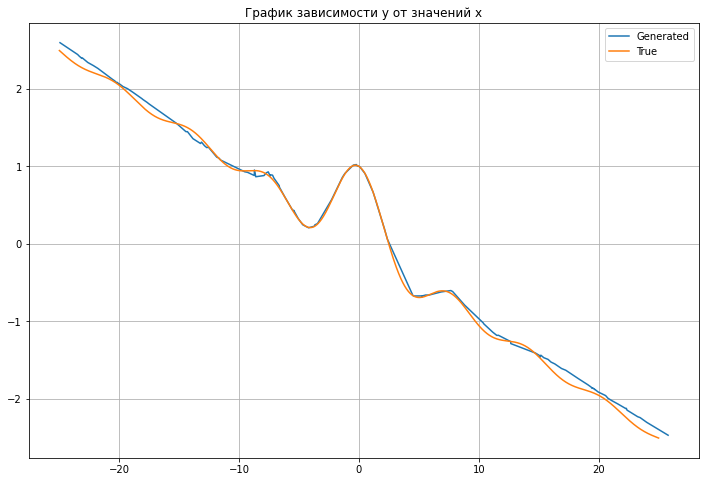

In [13]:
p = gen_xy_values.cpu().detach().numpy()[:,0].argsort()

plt.figure(figsize=(12, 8))
plt.title('График зависимости у от значений x')
plt.grid()
plt.plot(gen_xy_values.cpu().detach().numpy()[:,0][p], gen_xy_values.cpu().detach().numpy()[:,1][p], 
         label='Generated')
plt.plot(x, y, label='True')
plt.legend();